In [0]:
#Import libraries

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tensorflow.keras.preprocessing import image

import os
import cv2
from datetime import datetime
from glob import glob
from collections import Counter

# Plan:
1. Load data
2. Do train - test split
3. Convert images to pairs 
4. Generate Generators
4. Create model
5. Create loss
6. Evaluate model


# 1. Loading the data

In [2]:
# Load data from http://vision.ucsd.edu/content/yale-face-database
!wget -nc 'http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip'

File ‘yalefaces.zip’ already there; not retrieving.



In [3]:
# unzip data
!unzip yalefaces.zip

Archive:  yalefaces.zip
replace yalefaces/Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: yalefaces/Readme.txt    
  inflating: __MACOSX/yalefaces/._Readme.txt  
  inflating: yalefaces/subject01.gif  
  inflating: yalefaces/subject01.glasses  
  inflating: yalefaces/subject01.glasses.gif  
  inflating: yalefaces/subject01.happy  
  inflating: yalefaces/subject01.leftlight  
  inflating: yalefaces/subject01.noglasses  
  inflating: yalefaces/subject01.normal  
  inflating: yalefaces/subject01.rightlight  
  inflating: yalefaces/subject01.sad  
  inflating: yalefaces/subject01.sleepy  
  inflating: yalefaces/subject01.surprised  
  inflating: yalefaces/subject01.wink  
  inflating: yalefaces/subject02.centerlight  
  inflating: yalefaces/subject02.glasses  
  inflating: yalefaces/subject02.happy  
  inflating: yalefaces/subject02.leftlight  
  inflating: yalefaces/subject02.noglasses  
  inflating: yalefaces/subject02.normal  
  inflating: yalefaces/subject02.rightlight 

In [0]:
files = glob('yalefaces/subject*') # look for every file starts with 'subject'

In [0]:
np.random.shuffle(files)

In [6]:
N = len(files)
print('Number of files:', N)

Number of files: 166


In [0]:
H = 60
W = 80

def load_img(path):
  img = image.load_img(path, target_size=[H, W])
  img = image.img_to_array(img).astype('uint8')
  return img

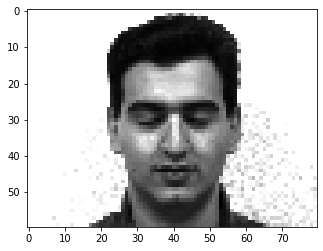

Image shape: (60, 80, 3)


In [8]:
img = load_img(np.random.choice(files))
plt.imshow(img)
plt.show()
print('Image shape:', img.shape)

In [9]:
# Looks like we have 3 channels but grayscale images
# Let's check if channels have the same values
(np.all(img[:,:,0]==img[:,:,1]), np.all(img[:,:,0]==img[:,:,2]))

(True, True)

In [0]:
def rgb_to_grayscale(img):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return gray

(60, 80)


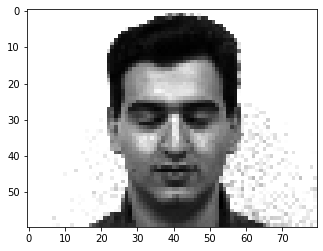

In [11]:
# Check if shape is (1, H,  W)
grayscaled = rgb_to_grayscale(img)
print(grayscaled.shape)
plt.imshow(grayscaled, cmap='gray')
plt.show()

In [0]:
# Load images as arrays
def make_data(files_path, shape):
  images = np.zeros(shape)
  for i, f in enumerate(files_path):
    img = rgb_to_grayscale(load_img(f)) / 255.
    images[i] = img
  return images  

# Making labels
def make_labels(files_path, shape):
  labels = np.zeros(shape)
  for i, f in enumerate(files_path):
    file_name = f.split('/', maxsplit=1)[-1]
    subject_name = file_name.split('.', maxsplit=1)[0]
    index = int(subject_name.replace('subject', ''))-1
    labels[i] = index  
  return labels

In [13]:
images = make_data(files, shape=(N, H, W))
labels = make_labels(files, shape=N)

print('Dataset shape:', images.shape)
print('Labels shape:', labels.shape)

Dataset shape: (166, 60, 80)
Labels shape: (166,)


# 2. Train-Test split

In [0]:
def split_data(images, labels, split=3):
  labels_count = Counter(labels)
  unique_labels = set(labels_count.keys())
  n_subjects = len(unique_labels)
  n_test = split * n_subjects
  n_train = N - n_test

  train_images = np.zeros([n_train]+[H, W])
  train_labels = np.zeros(n_train)
  test_images = np.zeros([n_test]+[H, W])
  test_labels = np.zeros(n_test)

  counter = {}
  train_idx = 0
  test_idx = 0

  for image, label in zip(images, labels):
    counter[label] = counter.get(label, 0)+1
    if counter[label] > split:
      train_images[train_idx] = image
      train_labels[train_idx] = label
      train_idx += 1
    else:
      test_images[test_idx] = image
      test_labels[test_idx] = label
      test_idx += 1  
        
  return train_images, train_labels, test_images, test_labels

In [15]:
train_images, train_labels, test_images, test_labels = split_data(images, labels, 3)

print('Train data shape:', train_images.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_images.shape)
print('Test labels shape:', test_labels.shape)

Train data shape: (121, 60, 80)
Train labels shape: (121,)
Test data shape: (45, 60, 80)
Test labels shape: (45,)


# 3. Generate pairs

In [0]:
def get_indices(train_images, train_labels, test_indices, test_labels):
  
  train_indices = {}
  test_indices = {}

  for i, label in enumerate(train_labels):
    if label not in train_indices:
      train_indices[label] = [i]
    else:
      train_indices[label].append(i)

  for i, label in enumerate(test_labels):
    if label not in test_indices:
      test_indices[label] = [i]
    else:
      test_indices[label].append(i)
  
  return train_indices, test_indices           

In [0]:
train_indices, test_indices = get_indices(train_images, train_labels, test_images, test_labels)

In [0]:
def generate_pairs(train_indices, test_indices):

  train_positives = []
  train_negatives = []
  test_positives = []
  test_negatives = []
  n_train = train_images.shape[0]
  n_test = test_images.shape[0]

  for labels, indices in train_indices.items():
    other_indices = set(range(n_train)) - set(indices)
    for i, idx1 in enumerate(indices):
      for idx2 in indices[i+1:]:
        train_positives.append((idx1, idx2))
      for idx2 in other_indices:
        train_negatives.append((idx1, idx2))

  for labels, indices in test_indices.items():
    other_indices = set(range(n_test)) - set(indices)
    for i, idx1 in enumerate(indices):
      for idx2 in indices[i+1:]:
        test_positives.append((idx1, idx1))
      for idx2 in other_indices:
        test_negatives.append((idx1, idx2)) 

  return train_positives, train_negatives, test_positives, test_negatives               

In [19]:
train_positives, train_negatives, test_positives, test_negatives = generate_pairs(train_indices, test_indices)

print('Number of train positive pairs:', len(train_positives))
print('Number of train negative pairs:', len(train_negatives))
print('Number of test positive pairs:', len(test_positives))
print('Number of test negative pairs:', len(test_negatives))

Number of train positive pairs: 428
Number of train negative pairs: 13664
Number of test positive pairs: 45
Number of test negative pairs: 1890


# 4. Train and Test generators

In [0]:
# Generators for generating balanced batches in training loop

batch_size = 64
def train_generator():
  n_batches = int(np.ceil(len(train_positives) / batch_size)) # rounded up because last batch will have less samples than the rest

  while True:
    np.random.shuffle(train_positives)
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    # get positive samples
    for i in range(n_batches):
      pos_batch_idxs = train_positives[i*batch_size : (i+1)*batch_size]
      j = 0
      for idx1, idx2 in pos_batch_idxs:
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 1
        j += 1

      # get negative samples
      neg_batch_idxs = np.random.choice(len(train_negatives), size=len(pos_batch_idxs), replace=False) # from 13664 take random *batch_size* elements
      for k in neg_batch_idxs:
        idx1, idx2 = train_negatives[k]
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 0
        j += 1 

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]
      # reshape for CNN
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)
      # convert our data to Tensor
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

In [0]:
def test_generator():
  n_batches = int(np.ceil(len(test_positives) / batch_size)) # rounded up because last batch will have less samples than the rest

  while True:
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    # get positive samples
    for i in range(n_batches):
      pos_batch_idxs = test_positives[i*batch_size: (i+1)*batch_size]
      j = 0
      for idx1, idx2 in pos_batch_idxs:
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 1
        j += 1

      # get negative samples
      neg_batch_idxs = np.random.choice(len(test_negatives), size=len(pos_batch_idxs), replace=False) # from 13664 take random *batch_size* elements
      for k in neg_batch_idxs:
        idx1, idx2 = test_negatives[k]
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 0
        j += 1 

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]
      # reshape for CNN
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)
      # convert our data to Tensor
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

# 5. Build a model

In [0]:
# Build siamese neural network that
# works with 2 different feature vectors and use the same weights

class SiameseNetwork(nn.Module):
  def __init__(self, feature_dim):
    super(SiameseNetwork, self).__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(13*18*64, 128),
        nn.ReLU(),
        nn.Linear(128, feature_dim)
    )

  def forward(self, x1, x2):
    feature1 = self.cnn(x1)
    feature2 = self.cnn(x2)  
    return torch.norm(feature1 - feature2, dim=-1)

In [0]:
def contrastive_loss(output, target):
  non_match = torch.nn.functional.relu(1 - output) 
  return torch.mean(target * output**2 + (1 - target) * non_match**2)

In [0]:
def train_model(model,
                loss,
                optimizer,
                train_gen,
                test_gen,
                train_steps_per_epoch,
                test_steps_per_epoch,
                n_epochs):
  train_history = np.zeros(n_epochs)
  test_history = np.zeros(n_epochs)
  
  for epoch in range(n_epochs):
    t0 = datetime.now()
    train_loss = []
    steps = 0
    for (x1, x2), y in train_gen:
      x1 = x1.to(device)
      x2 = x2.to(device)
      y = y.to(device)

      optimizer.zero_grad()
      outputs = model(x1, x2)
      loss_value = loss(outputs, y)
      loss_value.backward()
      optimizer.step()
      train_loss.append(loss_value.item())
      steps += 1
      if steps >= train_steps_per_epoch:
        break
    train_loss = np.mean(train_loss)

    test_loss = []
    steps = 0
    for (x1, x2), y in test_gen:
      x1 = x1.to(device)
      x2 = x2.to(device)
      y = y.to(device)
      outputs = model(x1, x2)
      loss_value = loss(outputs, y)
      test_loss.append(loss_value.item())
      steps += 1
      if steps >= test_steps_per_epoch:
        break
    test_loss = np.mean(test_loss)

    # Save loss history
    train_history[epoch] = train_loss
    test_history[epoch] = test_loss

    print('Epoch: {}/{} Train loss: {}, Test loss: {}'.format(epoch+1, n_epochs, train_loss, test_loss))

  return train_history, test_history    

In [0]:
# Define model and optimizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork(50)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

In [26]:
# Define batch size and steps per epoch
batch_size = 64
train_steps = int(np.ceil(len(train_positives) / batch_size))
test_steps = int(np.ceil(len(test_positives) / batch_size))

train_history, test_history = train_model(model,
                                          contrastive_loss,
                                          optimizer,
                                          train_generator(),
                                          test_generator(),
                                          train_steps,
                                          test_steps,
                                          20)

Epoch: 1/20 Train loss: 0.5945035368204117, Test loss: 0.03994444012641907
Epoch: 2/20 Train loss: 0.16577598878315516, Test loss: 0.05786259099841118
Epoch: 3/20 Train loss: 0.1295845987541335, Test loss: 0.022987892851233482
Epoch: 4/20 Train loss: 0.07980534966502871, Test loss: 0.041596319526433945
Epoch: 5/20 Train loss: 0.06665067427924701, Test loss: 0.03030443750321865
Epoch: 6/20 Train loss: 0.04830218053289822, Test loss: 0.013298052363097668
Epoch: 7/20 Train loss: 0.02850668158914362, Test loss: 0.018768392503261566
Epoch: 8/20 Train loss: 0.02004930323788098, Test loss: 0.00475713238120079
Epoch: 9/20 Train loss: 0.014292116409965925, Test loss: 0.0032577766105532646
Epoch: 10/20 Train loss: 0.010372689392949854, Test loss: 0.01792260631918907
Epoch: 11/20 Train loss: 0.008727999470595802, Test loss: 0.009512879885733128
Epoch: 12/20 Train loss: 0.005965771486184427, Test loss: 0.0033546965569257736
Epoch: 13/20 Train loss: 0.005545376168031778, Test loss: 0.00784962158650

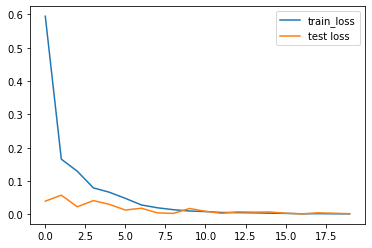

In [27]:
plt.plot(train_history, label='train_loss')
plt.plot(test_history, label='test loss')
plt.legend()
plt.show()

# 6. Evaluate the model

In [0]:
# Convenience function to make predictions
def predict(x1, x2):
  x1 = torch.from_numpy(x1).float()
  x2 = torch.from_numpy(x2).float()
  x1 = x1.to(device)
  x2 = x2.to(device)
  with torch.no_grad():
    distances = model(x1, x2)
    distances = distances.cpu().numpy()
    return distances.flatten()

In [0]:
# Accuracy isn't best metric for imbalanced classes
# Use sensitivity and specificity instead

def get_train_acc(threshold=0.7, batch_size=64):
  pos_distances = []
  neg_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  # positive pairs
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))

  for i in range(n_batches):
    pos_batch_idxs = train_positives[i*batch_size: (i+1)*batch_size]
    j = 0
    for idx1, idx2 in pos_batch_idxs:
      x_batch_1[j] = train_images[idx1]
      x_batch_2[j] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    dists = predict(x1, x2)
    pos_distances += dists.tolist()

    tp += (dists < threshold).sum()
    fn += (dists > threshold).sum()

    n_batches = int(np.ceil(len(train_negatives) / batch_size))
    x_batch_1 = np.zeros((batch_size, 1, H, W))
    x_batch_2 = np.zeros((batch_size, 1, H, W))

  # negative pairs
  n_batches = int(np.ceil(len(train_negatives) / batch_size))
  for i in range(n_batches):
    neg_batch_idxs = train_negatives[i*batch_size: (i+1)*batch_size]
    j = 0
    for idx1, idx2 in neg_batch_idxs:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1
    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    dists = predict(x1, x2)
    neg_distances += dists.tolist()

    fp += (dists < threshold).sum()
    tn += (dists > threshold).sum()

  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print('Train sensitivity: {}  Train specificity: {}'.format(sensitivity, specificity))
  
  return pos_distances, neg_distances

In [0]:
# The same procedure for test set

def get_test_acc(threshold=0.7, batch_size=64):
  pos_distances = []
  neg_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  # positive pairs
  n_batches = int(np.ceil(len(test_positives) / batch_size))
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))

  for i in range(n_batches):
    pos_batch_idxs = test_positives[i*batch_size: (i+1)*batch_size]
    j = 0
    for idx1, idx2 in pos_batch_idxs:
      x_batch_1[j] = test_images[idx1]
      x_batch_2[j] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    dists = predict(x1, x2)
    pos_distances += dists.tolist()

    tp += (dists < threshold).sum()
    fn += (dists > threshold).sum()

    n_batches = int(np.ceil(len(test_negatives) / batch_size))
    x_batch_1 = np.zeros((batch_size, 1, H, W))
    x_batch_2 = np.zeros((batch_size, 1, H, W))

  # negative pairs
  n_batches = int(np.ceil(len(test_negatives) / batch_size))
  for i in range(n_batches):
    neg_batch_idxs = test_negatives[i*batch_size: (i+1)*batch_size]
    j = 0
    for idx1, idx2 in neg_batch_idxs:
      x_batch_1[j] = test_images[idx1]
      x_batch_2[j] = test_images[idx2]
      j += 1
    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    dists = predict(x1, x2)
    neg_distances += dists.tolist()

    fp += (dists < threshold).sum()
    tn += (dists > threshold).sum()

  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print('Test sensitivity: {}  Test specificity: {}'.format(sensitivity, specificity))
  
  return pos_distances, neg_distances

In [31]:
train_pos_distances, train_neg_distances = get_train_acc()

Train sensitivity: 1.0  Train specificity: 0.9811182669789227


In [32]:
test_pos_distances, test_neg_distances = get_test_acc()

Test sensitivity: 1.0  Test specificity: 0.9592592592592593


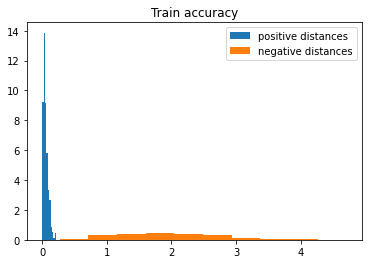

In [33]:
plt.hist(train_pos_distances, density=True, label='positive distances')
plt.hist(train_neg_distances, density=True, label='negative distances')
plt.title('Train accuracy')
plt.legend()
plt.show()

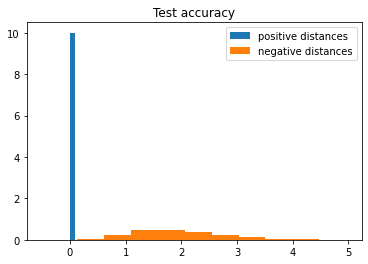

In [34]:
plt.hist(test_pos_distances, density=True, label='positive distances')
plt.hist(test_neg_distances, density=True, label='negative distances')
plt.title('Test accuracy')
plt.legend()
plt.show()